<a href="https://colab.research.google.com/github/data-in-galaxy/Vector-Databases/blob/main/vectordb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create embeddings

Embedding MNIST images and natural language sentences into vectors

## Embed images

Pass images of handwritten digits through the workflow until the output matches the input
- The output is created using the embedding vectors

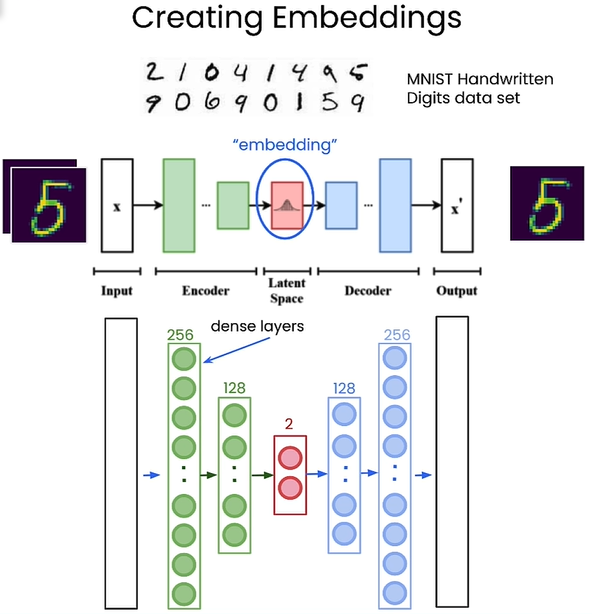

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [2]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [4]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [5]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2 # objective: generate vector embeddings of 2 dimension

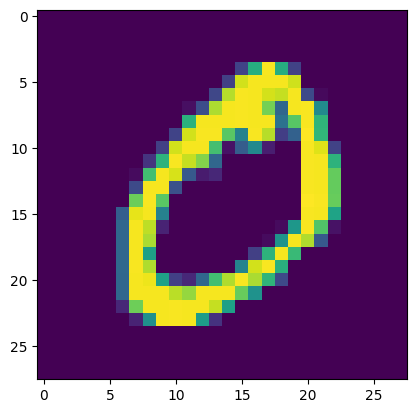

In [6]:
# Example of a training image
plt.imshow(x_tr[1]);

In [7]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [8]:
# Construct encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [9]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [10]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [11]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

Epoch 1/50
600/600 [==============================] - 9s 14ms/step - loss: 200.6905 - val_loss: 174.3946
Epoch 2/50
600/600 [==============================] - 5s 9ms/step - loss: 167.9798 - val_loss: 164.5242
Epoch 3/50
600/600 [==============================] - 6s 10ms/step - loss: 161.7762 - val_loss: 159.4947
Epoch 4/50
600/600 [==============================] - 5s 9ms/step - loss: 157.2644 - val_loss: 155.4565
Epoch 5/50
600/600 [==============================] - 6s 10ms/step - loss: 153.7970 - val_loss: 152.3737
Epoch 6/50
600/600 [==============================] - 5s 9ms/step - loss: 151.2404 - val_loss: 150.5574
Epoch 7/50
600/600 [==============================] - 6s 10ms/step - loss: 149.2804 - val_loss: 148.9068
Epoch 8/50
600/600 [==============================] - 5s 9ms/step - loss: 147.5221 - val_loss: 147.2686
Epoch 9/50
600/600 [==============================] - 6s 10ms/step - loss: 145.9907 - val_loss: 146.7552
Epoch 10/50
600/600 [==============================] - 5s 9

### Visualize embeddings

In [12]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

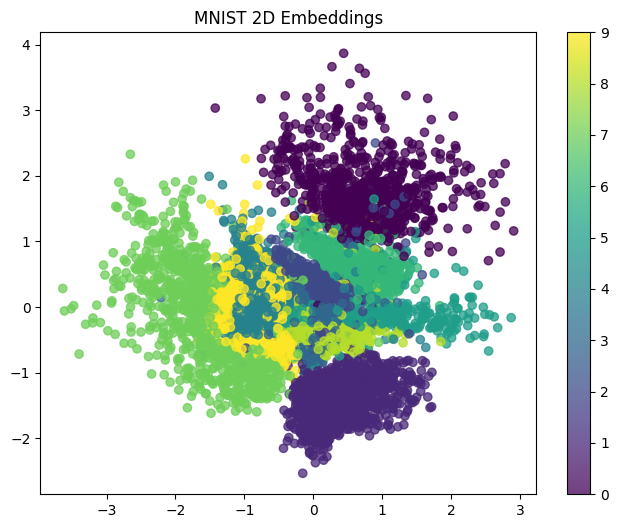

In [13]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

### Example: Compare 3 embeddings

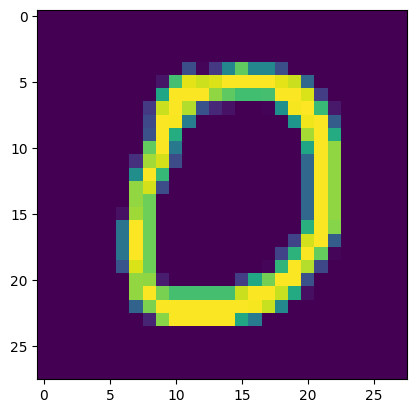

In [14]:
plt.imshow(x_te_flat[10].reshape(28,28));

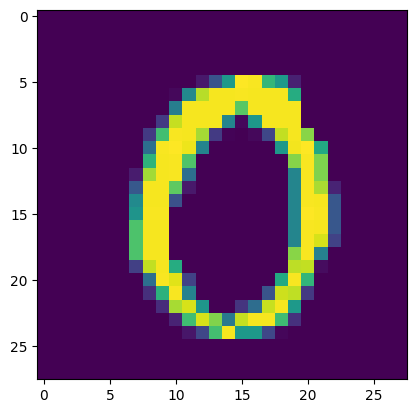

In [15]:
plt.imshow(x_te_flat[13].reshape(28,28));

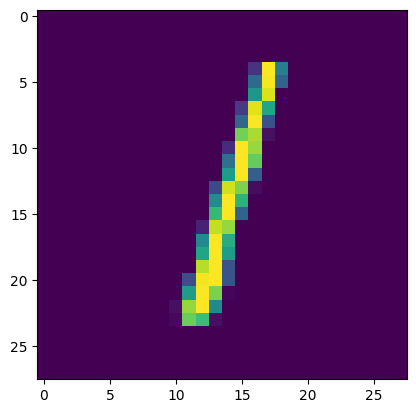

In [16]:
plt.imshow(x_te_flat[2].reshape(28,28));

In [17]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [0.5555713 1.6861293]
Embedding for the second ZERO is [0.58398473 1.3622099 ]
Embedding for the ONE is         [ 0.6190342 -1.7063524]


## Embed text

Using Transformer to embed text

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [20]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [21]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.3706197   0.2641425   0.21265654 ...  0.14994532 -0.2579492
  -0.2397075 ]
 [ 0.66933304  0.40094963 -0.48208407 ...  0.10645866 -1.5067165
  -0.01547357]
 [-0.2655591   0.11172403 -0.14733036 ...  0.42197466  0.88394594
   0.10763935]]


In [22]:
embedding.shape

(3, 384)

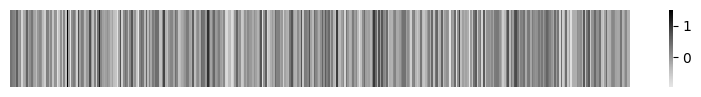

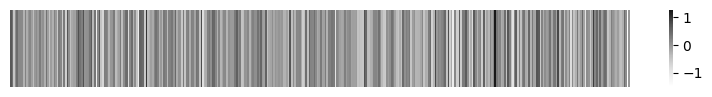

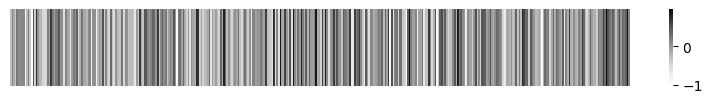

In [23]:
# Visualize vector as barcodes
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## Distance between Image Embeddings

There are many ways to calculate the distances between two vectors.

We will look at 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

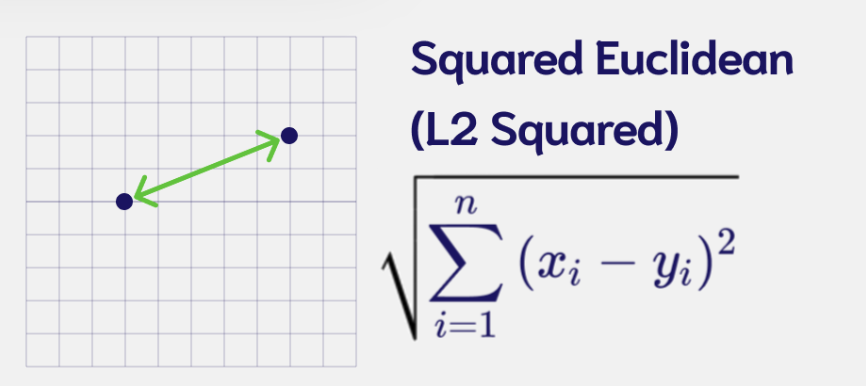

In [24]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.32516320497619433


In [25]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

0.32516322

In [26]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.32516322
Distance zeroA-one:   3.3930755
Distance zeroB-one:   3.0687625


### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

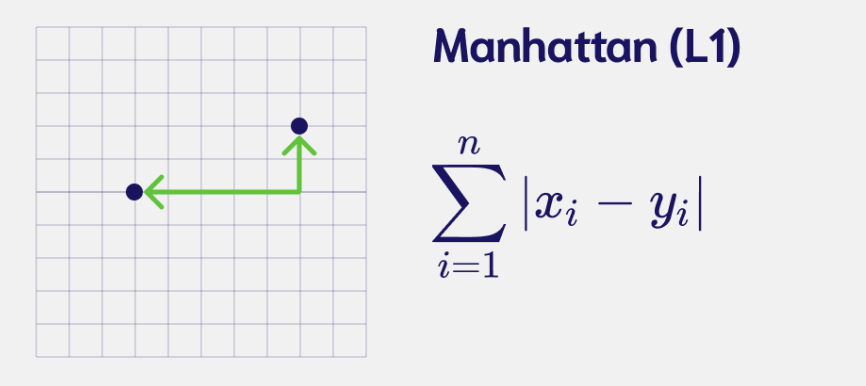

In [27]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

0.35233283


In [28]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

0.35233283

In [29]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 0.35233283
Distance zeroA-one:   3.4559445
Distance zeroB-one:   3.1036117


### Dot Product
Measures the magnitude of the projection of one vector onto the other.

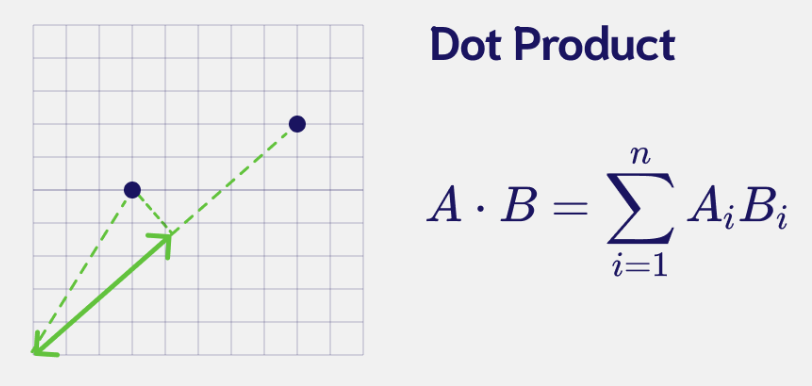

In [30]:
# Dot Product
np.dot(zero_A,zero_B)

2.6213074

In [31]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

Distance zeroA-zeroB: 2.6213074
Distance zeroA-one:   -2.5332131
Distance zeroB-one:   -1.9629037


### Cosine Distance
Measure the difference in directionality between vectors.

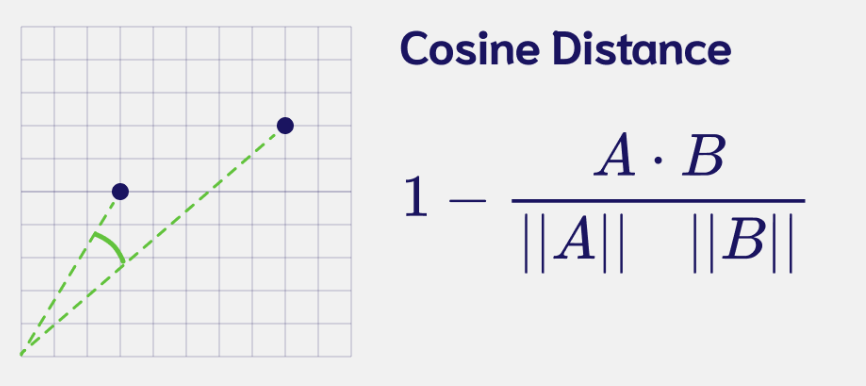

In [32]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.003757


In [33]:
zero_A/zero_B

# Similar

array([0.9513456, 1.2377896], dtype=float32)

In [34]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [35]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.003757
Distance zeroA-one:    1.786109
Distance zeroB-one:    1.729627


## Distance between Text Embeddings

Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [36]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.49789
Distance 0-2: 2.0785775
Distance 1-2: 4.0192113


In [37]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350335538387299
Distance 0-2:  0.9639393128454685
Distance 1-2:  0.9288790971040726


# Search for similar vectors

## K Nearest Neighbors

In [4]:
import numpy as np
!pip install matplotlib
import matplotlib.pyplot as plt
!pip install scikit-learn
from sklearn.neighbors import NearestNeighbors
import time
np.random.seed(42)

In [40]:
# Generate 20 data points with 2 dimensions
X = np.random.rand(20,2)

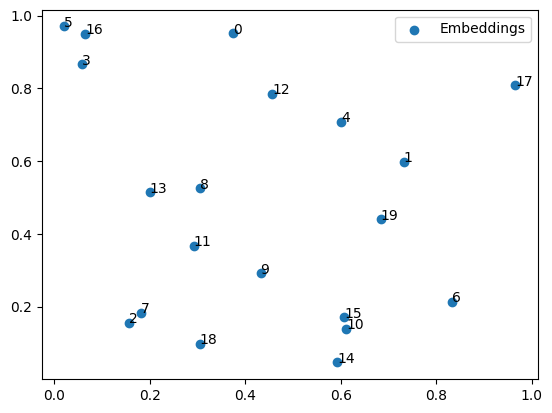

In [41]:
# Display Embeddings
n = range(len(X))

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], label='Embeddings')
ax.legend()

for i, txt in enumerate(n):
    ax.annotate(txt, (X[i,0], X[i,1]))

In [42]:
# Brute force KNN
k = 4

neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
neigh.fit(X)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=4)

In [43]:
neighbours = neigh.kneighbors([[0.45,0.2]], k, return_distance=True)
print(neighbours)

# vector 9, 15, 10, 18 are most similar

(array([[0.09299859, 0.16027853, 0.1727928 , 0.17778682]]), array([[ 9, 15, 10, 18]]))


In [44]:
t0 = time.time()
neighbours = neigh.kneighbors([[0.45,0.2]], k, return_distance=True)
t1 = time.time()

query_time = t1-t0
print(f"Runtime: {query_time: .4f} seconds")

# Take very little time to run brute force KNN

Runtime:  0.0020 seconds


In [16]:
# test speed of finding nearest neighbors from N objects
def speed_test(count):
    # generate random objects
    data = np.random.rand(count,2)

    # prepare brute force index
    k=4
    neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
    neigh.fit(data)

    # measure time for a brute force query
    t0 = time.time()
    neighbours = neigh.kneighbors([[0.45,0.2]], k, return_distance=True)
    t1 = time.time()

    total_time = t1-t0
    print (f"Runtime: {total_time: .4f}")

    return total_time

In [46]:
time20k = speed_test(20_000)

Runtime:  0.0014


In [47]:
# Brute force examples
time200k = speed_test(200_000)
time2m = speed_test(2_000_000)
time20m = speed_test(20_000_000)
time200m = speed_test(200_000_000)

Runtime:  0.0051
Runtime:  0.0295
Runtime:  0.2964
Runtime:  8.7264


#### Brute force KNN implemented by hand on 768 dimensional embeddings

In [3]:
documents = 1000
dimensions = 768

embeddings = np.random.randn(documents, dimensions) # 1000 documents, 768-dimensional embeddings
embeddings = embeddings / np.sqrt((embeddings**2).sum(1, keepdims=True)) # L2 normalize the rows, as is common

query = np.random.randn(768) # the query vector
query = query / np.sqrt((query**2).sum()) # normalize query

In [5]:
# kNN
t0 = time.time()
# Calculate Dot Product between the query and all data items
similarities = embeddings.dot(query)
# Sort results
sorted_ix = np.argsort(-similarities)
t1 = time.time()

total = t1-t0
print(f"Runtime for dim={dimensions}, documents_n={documents}: {np.round(total,3)} seconds")

print("Top 5 results:")
for k in sorted_ix[:5]:
    print(f"Point: {k}, Similarity: {similarities[k]}")

Runtime for dim=768, documents_n=1000: 0.038 seconds
Top 5 results:
Point: 529, Similarity: 0.10256232104552798
Point: 388, Similarity: 0.10223015495110249
Point: 703, Similarity: 0.10176865080229555
Point: 116, Similarity: 0.09476283055934709
Point: 152, Similarity: 0.09313182294088883


In [6]:
n_runs = [1_000, 10_000, 100_000, 500_000]

for n in n_runs:
    embeddings = np.random.randn(n, dimensions) #768-dimensional embeddings
    query = np.random.randn(768) # the query vector

    t0 = time.time()
    similarities = embeddings.dot(query)
    sorted_ix = np.argsort(-similarities)
    t1 = time.time()

    total = t1-t0
    print(f"Runtime for 1 query with dim={dimensions}, documents_n={n}: {np.round(total,3)} seconds")

Runtime for 1 query with dim=768, documents_n=1000: 0.001 seconds
Runtime for 1 query with dim=768, documents_n=10000: 0.006 seconds
Runtime for 1 query with dim=768, documents_n=100000: 0.057 seconds
Runtime for 1 query with dim=768, documents_n=500000: 0.303 seconds


In [7]:
print (f"To run 1,000 queries: {total * 1_000/60 : .2f} minutes")

To run 1,000 queries:  5.05 minutes


## Approximate Nearest Neighbors

An alternative approach to search for similar vectors
-> the result vector are not perfect, but reasonably similar to the query vector

In [10]:
from random import random, randint
from math import floor, log
import networkx as nx # graph network
import numpy as np
import matplotlib as mtplt
from matplotlib import pyplot as plt
!pip install utils
from utils import *

vec_num = 40 # Number of vectors (nodes)
dim = 2 ## Dimention. Set to be 2. All the graph plots are for dim 2. If changed, then plots should be commented.
m_nearest_neighbor = 2 # M Nearest Neigbor used in construction of the Navigable Small World (NSW)

vec_pos = np.random.uniform(size=(vec_num, dim)) # list of vectors to search through

In [11]:
# Query Vector
query_vec = [0.5, 0.5]

nodes = []
nodes.append(("Q",{"pos": query_vec}))

G_query = nx.Graph()
G_query.add_nodes_from(nodes)

print("nodes = ", nodes, flush=True)

pos_query=nx.get_node_attributes(G_query,'pos') # create the position for the query vector

nodes =  [('Q', {'pos': [0.5, 0.5]})]


### Brute Force KNN

In [21]:
# Define brute force nearest neighbor function
def nearest_neighbor(vec_pos, query_vec, k):

  # calculate euclidean distance between query vector and other vectors
  distances = np.linalg.norm(vec_pos - query_vec, axis=1)

  # Find indices of the k-nearest neighbors
  G_lin_indices = np.argpartition(distances, k)[:k]


  # Create a NetworkX graph object for G_lin
  G_lin = nx.Graph()
  for i, idx in enumerate(G_lin_indices):
      G_lin.add_node(idx, pos=vec_pos[idx])

  # Get the vectors corresponding to k-nearest neighbors
  G_best_vectors = vec_pos[G_lin_indices]

  # Create a NetworkX graph object for G_best
  G_best = nx.Graph()
  for i, vector in enumerate(G_best_vectors):
      G_best.add_node(i, pos=vector)


  return G_lin, G_best

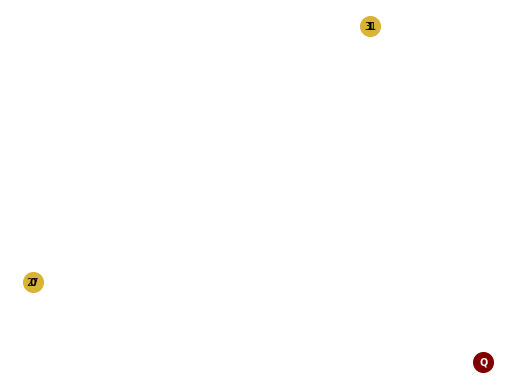

In [22]:
(G_lin, G_best) = nearest_neighbor(vec_pos,query_vec,2) # Find the most similar vector to the query vector

# Graph the vector on the graph
pos_lin=nx.get_node_attributes(G_lin,'pos')
pos_best=nx.get_node_attributes(G_best,'pos')

fig, axs = plt.subplots()

nx.draw(G_lin, pos_lin, with_labels=True, node_size=150, node_color=[[0.8,0.8,1]], width=0.0, font_size=7, ax = axs)
nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.5,0,0]], font_color='white', width=0.5, font_size=7, font_weight='bold', ax = axs)
nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)